# Shift Transformation

In [1]:
## Notebook settings
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
## fastai imports
from fastai.basics import *
from fastai.data_block import ItemList
from fastai.vision import *
from exp.nb_AudioCommon import *
from exp.nb_DataBlock import *
from exp.nb_DataAugmentation import *

In [3]:
## The actual url is http://www.openslr.org/resources/45/ST-AEDS-20180100_1-OS.tgz
## but we need to strip off the extension otherwise fastai gets confused.
data_url = 'http://www.openslr.org/resources/45/ST-AEDS-20180100_1-OS'
## Need this because the source tar file doesn't extract to its own folder
data_folder = datapath4file(url2name(data_url))
untar_data(data_url, dest=data_folder)

PosixPath('/home/h/.fastai/data/ST-AEDS-20180100_1-OS/ST-AEDS-20180100_1-OS')

In [4]:
audios = AudioList.from_folder(data_folder); audios

AudioList (3842 items)
AudioItem: 6.24sec (99840 @ 16000hz).,AudioItem: 7.4sec (118400 @ 16000hz).,AudioItem: 2.84sec (45440 @ 16000hz).,AudioItem: 3.36sec (53760 @ 16000hz).,AudioItem: 3.84sec (61440 @ 16000hz).
Path: /home/h/.fastai/data/ST-AEDS-20180100_1-OS

160000

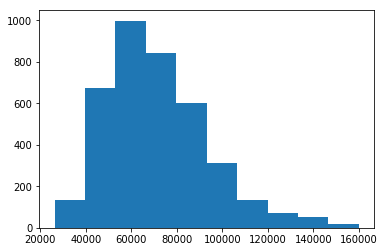

In [5]:
audio_lengths = tensor([a.data.sig.shape[0] for a in audios])
plt.hist(audio_lengths);
audio_lengths.max().item()

In [6]:
def make_learner(data):
    newlayer = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    newlayer = newlayer.cuda() # Our layer should use cuda, since the rest of the model will.
    ## Standard learner
    learn = cnn_learner(data, models.resnet50, metrics=accuracy)
    ## Replace the first layer in the resnet18 model with our first layer
    learn.model[0][0] = newlayer
    learn.unfreeze()
    return learn

In [7]:
## Regex to get the speaker ID in our file name (our label)
label_pattern = r'_([mf]\d+)_'
bs = 55
label_data = (audios
        .split_by_rand_pct(0.2, seed=2)
        .label_from_re(label_pattern)
 )

In [8]:
def tfms_sr(resample_rate):
    return get_audio_transforms(resample_rate=resample_rate,
                            spectro=True,
                            mx_to_pad=100000,
                            white_noise=False,
                            modulate_volume=False,
                            random_cutout=False,
                            pad_with_silence=False,
                            pitch_warp=False,
                            down_and_up=False,
                            shift_max_pct=.6,
                            to_db_scale=True,
    )

torch.Size([1, 128, 501])


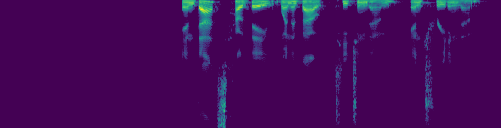

In [9]:
tfms = tfms_sr(None)
db = label_data.transform(tfms).databunch(bs=bs)
db.train_ds[1][0].show()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


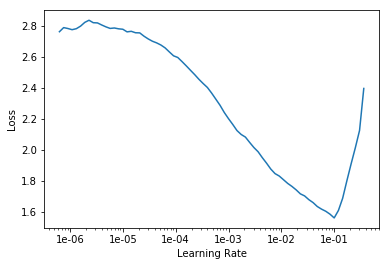

In [10]:
learn = make_learner(db)
learn.lr_find()
learn.recorder.plot()

In [11]:
learn.fit_one_cycle(15, slice(1e-4, 4e-3))

epoch,train_loss,valid_loss,accuracy,time
0,1.207757,0.565034,0.786458,00:25
1,0.570098,0.353469,0.868490,00:24
2,0.355059,0.487557,0.834635,00:24
3,0.251053,1.174039,0.704427,00:23
4,0.192678,0.144946,0.949219,00:23
5,0.151944,0.409922,0.876302,00:24
6,0.121929,0.196230,0.937500,00:23
7,0.097373,0.051772,0.983073,00:22
8,0.077461,0.085389,0.972656,00:23
9,0.047341,0.093441,0.970052,00:23


[('f0001', 'f0002', 1),
 ('f0002', 'f0001', 1),
 ('f0002', 'f0003', 1),
 ('f0004', 'f0001', 1)]

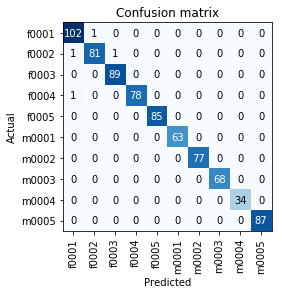

In [13]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
interp.most_confused()